## Performing PCA with an Undercomplete Linear Autoencoder

In [15]:
import tensorflow as tf

tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

In [16]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) 
X += 0.28 * np.random.randn(m, 3) 
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]

In [19]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


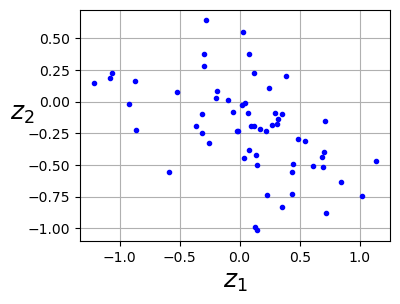

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [24]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32)/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
tf.random.set_seed(42)
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28, activation="relu"),
    tf.keras.layers.Reshape([28, 28])
])

stacked_autoencoder = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_autoencoder.compile(loss="mse", optimizer="nadam")
history = stacked_autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0502 - val_loss: 0.0322
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0309 - val_loss: 0.0299
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0277 - val_loss: 0.0272
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0261 - val_loss: 0.0264
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0253 - val_loss: 0.0259
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0250 - val_loss: 0.0257
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0248 - val_loss: 0.0254
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0245 - val_loss: 0.0247
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0240 - val_loss: 0.0246
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0237 - val_loss: 0.0241
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 12/20
1719/1719 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


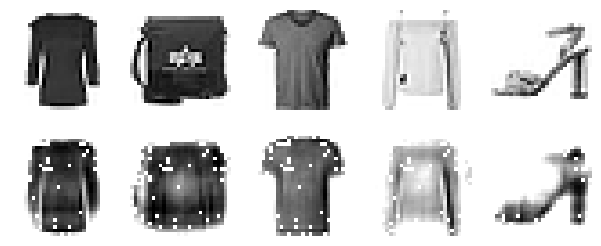

In [37]:
import numpy as np

def plot_reconstruction(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstruction(stacked_autoencoder)
plt.show()

## Tying Weights

In [56]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

   
    def build(self, batch_input_shape):
        if not self.dense.built:
            raise ValueError("The `Dense` layer must be built before using `DenseTranspose`.")
    
        self.biases = self.add_weight(name="bias",
                                      shape=(self.dense.weights[0].shape[0],),
                                      initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [58]:
tf.random.set_seed(42)

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])


dummy_input = tf.keras.Input(shape=(28 * 28,))
dense_1(dummy_input)
dense_2(dense_1.output)

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0330 - val_loss: 0.0164
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0134 - val_loss: 0.0134


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


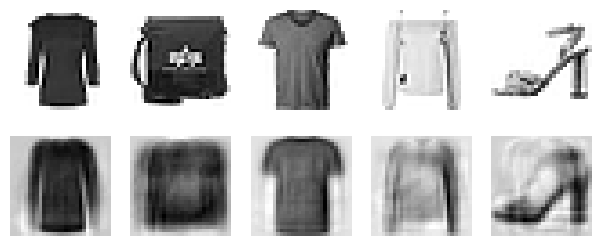

In [62]:
plot_reconstruction(tied_ae)
plt.show()